__Домашнее задание к уроку №4__

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention.

Поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [23]:
import numpy as np
import pandas as pd

In [25]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (1).csv


In [26]:
df = pd.read_csv('data.csv', sep=',')

df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [27]:
df.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)

In [28]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [29]:
df['treatment'] = df['treatment'].map({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})

2. Сделать разбиение набора данных на тренировочную и тестовую выборки

In [30]:
from sklearn.model_selection import train_test_split

features = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel', 'treatment']
target = 'target'
X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[target], test_size=0.3, random_state=42)

In [32]:
treat_train = X_train['treatment']
X_train = X_train.drop('treatment', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [42]:
treat_val = X_test['treatment']
X_val = X_test.drop('treatment', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [40]:
cat_features = ['zip_code','channel']
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

3. провести uplift-моделирование 3 способами:

*   одна модель с признаком коммуникации (S-learner)
*   модель с трансформацией таргета
*   вариант с двумя независимыми моделями




Обучим модель S-learner:

In [38]:
!pip install scikit-uplift catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [39]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier

In [41]:
sm = SoloModel(
    CatBoostClassifier(iterations=25, random_state=42, silent=True, cat_features=cat_features)
)

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

In [44]:
sm_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_1)
models_results['uplift@20%'].append(sm_score_2)

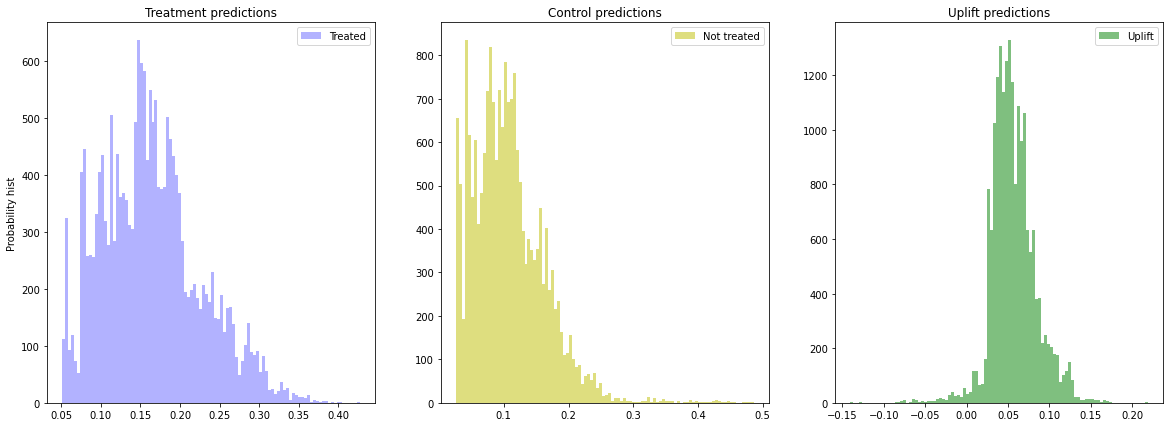

In [45]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [47]:
print('uplift@10%:', sm_score_1)
print('uplift@20%:', sm_score_2)

uplift@10%: 0.12053781619205842
uplift@20%: 0.09435873840987968


Обучим модель с изменением таргета:

In [48]:
from sklift.models import ClassTransformation


ct = ClassTransformation(
    CatBoostClassifier(iterations=25, random_state=42, silent=True, cat_features=cat_features)
)
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_1)
models_results['uplift@20%'].append(ct_score_2)

In [49]:
print('uplift@10%:', ct_score_1)
print('uplift@20%:', ct_score_2)

uplift@10%: 0.12298099371336149
uplift@20%: 0.09875346218185252


Обучим две независимые модели:

In [53]:
from sklift.models import TwoModels


tm = TwoModels(
    CatBoostClassifier(iterations=25, random_state=42, silent=True, cat_features=cat_features),
    CatBoostClassifier(iterations=25, random_state=42, silent=True, cat_features=cat_features),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_val)

tm_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_1)
models_results['uplift@20%'].append(tm_score_2)

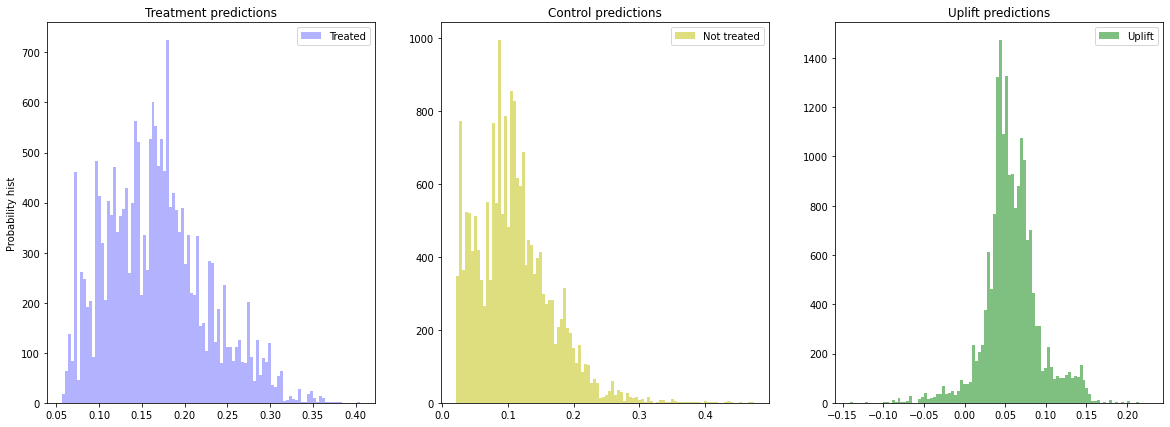

In [54]:
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [55]:
print('uplift@10%:', tm_score_1)
print('uplift@20%:', tm_score_2)

uplift@10%: 0.10875738259208573
uplift@20%: 0.09627257464448838


4. В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей.

In [56]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.122981,0.098753
0,SoloModel,0.120538,0.094359
2,TwoModels,0.108757,0.096273


Более высокий процент положительного результата взаимодействия с клиентами предсказывает модель с трансформацией таргета как для 10%, так и для 20% выборки.